# 手写数字全连接模型 

## 关于批次的模糊点补充  
在深度学习领域，"批次"（batch）和"批"实际上是同一个概念的不同翻译或表述方式。通常，在提到神经网络训练时，我们会使用"批次"这个术语来描述一次提供给模型进行前向传播和反向传播的数据量。

### 批次（Batch）

1. **定义**：批次是指在训练过程中用于一次更新权重的样本集合。简单来说，就是每次迭代中使用的数据子集。
   
2. **作用**：
   - **加速计算**：通过并行处理一批数据而不是逐个处理单个数据点，可以更高效地利用GPU等硬件资源，从而加快训练速度。
   - **改善收敛性**：批量梯度下降可以在减少参数更新的方差的同时，保持较低的计算成本，有助于更平稳地收敛到全局最小值。
   
3. **类型**：
   - **全批量（Full Batch）**：使用整个训练集来进行一次参数更新。对于大型数据集来说，这可能不太实际，因为需要大量的内存和计算能力。
   - **小批量（Mini-batch）**：这是最常用的方式，指的是将数据集分成多个小批次，每个批次包含一定数量的样本。这种方法能够在计算效率和收敛速度之间取得平衡。
   - **在线学习（Online Learning）/ 单例批次（Batch size of 1）**：每使用一个样本就更新一次模型参数。这种方式适用于流数据或者当数据量非常大而无法全部加载到内存中的情况。

4. **选择合适的批次大小**：
   - 批次大小的选择对模型性能有显著影响。较小的批次大小可以引入噪声，帮助跳出局部最优解；较大的批次大小则能提高计算效率，并且在某些情况下能够达到更好的泛化效果。但是，批次太大可能导致内存不足的问题。

总之，在深度学习中讨论“批次”或“批”的时候，都是指在训练神经网络时一次性输入模型进行训练的一组数据。正确选择批次大小是优化模型训练过程的一个重要方面。

## squeeze的作用就是删除维度为1的维度

In [1]:
import torch 
from torch import nn 
import torch.nn.functional as F 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from torch.utils.data import TensorDataset,DataLoader 
from sklearn.model_selection import train_test_split

## 模板代码 

### 创建fit()函数

In [2]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
   
    #创建俩列表接收损失值和精度值
    train_loss_lst = []
    train_acc_lst = []
    tst_loss_lst=[]
    tst_acc_lst=[]
  
    Model_m.train()  # 设置为训练模式
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
   
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了灯饰可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval()
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


### 创建模型

```python
class Model(nn.Module):
    def __init__(self): 
        super().__init__() 
        self.liner_1 = nn.Linear() 
        self.liner_2 = nn.Linear()  
        self.liner_3 = nn.Linear() 
    #定义前向传播  
    def forward(self,input): 
        pass 

model = Model()
```

### 创建损失函数和优化函数

```python
loss_fn = nn.CrossEntropyLoss()
optim = nn.optim.xxx(model.parameters(),lr=0.001) #传入要优化的模型的参数并指定学习率
```

### 定义batch和接收返回值以及训练

```python
batch = 8 #定义batchsize
DS_train = TensorDataset(train_x,train_y)
DL_train = DataLoader(DS_train,batch_size=batch,shuffle=True)

DS_test = TensorDataset(test_x,test_y)
DL_test = DataLoader(DS_test,batch_size=batch)  

epochs = 50 

train_loss_gpu=[] 
train_acc_gpu =[] 
tst_loss_gpu = [] 
tst_acc_gpu=[] 
for epoch in range(epochs): 
    epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc = fit_gpu(Train_DL=DL_train,TST_DL=DL_test,Model_m=model_gpu,epoch_=epoch,optim=optim_gpu,loss_fn=loss_fn_gpu)
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
```

## 卷积神经网络

### 手写数字分类

##### torchvision内置了常用的数据集和模型

为了方便为我们转换数据集,它还内置了一个transform方法

In [3]:
import torchvision
from torchvision import datasets, transforms

In [4]:
datasets??

Type:        module
String form: <module 'torchvision.datasets' from 'D:\\venvs\\dl\\Lib\\site-packages\\torchvision\\datasets\\__init__.py'>
File:        d:\venvs\dl\lib\site-packages\torchvision\datasets\__init__.py
Source:     
from ._optical_flow import FlyingChairs, FlyingThings3D, HD1K, KittiFlow, Sintel
from ._stereo_matching import (
    CarlaStereo,
    CREStereo,
    ETH3DStereo,
    FallingThingsStereo,
    InStereo2k,
    Kitti2012Stereo,
    Kitti2015Stereo,
    Middlebury2014Stereo,
    SceneFlowStereo,
    SintelStereo,
)
from .caltech import Caltech101, Caltech256
from .celeba import CelebA
from .cifar import CIFAR10, CIFAR100
from .cityscapes import Cityscapes
from .clevr import CLEVRClassification
from .coco import CocoCaptions, CocoDetection
from .country211 import Country211
from .dtd import DTD
from .eurosat import EuroSAT
from .fakedata import FakeData
from .fer2013 import FER2013
from .fgvc_aircraft import FGVCAircraft
from .flickr import Flickr30k, Flickr8k
from

### 加载数据集

### transforms.ToTensor的两个作用就是 
1. 将读取的数据转换为张量
2. 将数据归一化(如图片数据),转为(0-1)之间的数

#### 准备训练集

In [4]:
transformation = transforms.Compose(
    [
        transforms.ToTensor(), #将读取的数据转换为张量
        # transforms.Normalize() #初学不建议
        #标准化到-1~1之间
        
    ]
)

In [5]:

DS_Train = datasets.MNIST(
    './dataset/', #指定数据的下载位置 
    train=True, #声明是Train数据 
    transform=transformation, #要做的变换
    download=False, #是否下载,这里我已经下载了,就不浪费流量了
)

In [6]:
type(DS_Train)

torchvision.datasets.mnist.MNIST

#### 准备测试集

In [7]:
DS_Test = datasets.MNIST(
    './dataset/', #指定数据的下载位置 
    train=False, #非Train数据集 
    transform=transformation, #要做的变换
    download=False, #是否下载
)

注意,直接返回的就是tensordataset那样的数据集,所以可以直接下一步处理成dataloader

In [8]:
DL_train = DataLoader(DS_Train,batch_size=64,shuffle=True)
DL_test = DataLoader(DS_Test,batch_size=256,shuffle=False)
#测试集并不需要反向传播,所以占用资源比较小,所以可以提升测试集
# 的batchsize

In [9]:
type(DL_train)

torch.utils.data.dataloader.DataLoader

#### 看看数据集长什么样

拿出一个批次,看看这玩意儿长什么样子

#### 注意这玩意儿有俩返回值,一个是图片,一个是图片对应的标签

In [10]:
img64,labels = next(iter(DL_train))

In [11]:
img64.shape

torch.Size([64, 1, 28, 28])

batchsize是64,一个通道(chanel),$28\times28$ 的图像（n,c,h,w）

在pytorch里面图片的表示形式就是  
$(n(batch),c(chanel),h(height),w(width))$

取出第一张图片

In [12]:
imgs = img64[0] 

In [13]:
imgs.shape

torch.Size([1, 28, 28])

转换为ndarry,但是第一个维度我们并不需要,  
所以利用squeeze将其去掉

In [14]:
img = imgs.numpy()
img = np.squeeze(img)

In [15]:
img.shape

(28, 28)

#### 绘制图片 

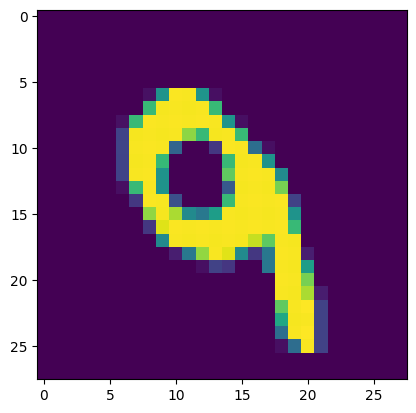

In [16]:
plt.imshow(img)

#### 查看对应的标签数据

In [17]:
labels[0]

tensor(9)

可以看到对应的是正确的

定义一个函数imshow用来绘制图片

In [18]:
def imshow(img):  
    npimg = img.numpy()
    img_ = np.squeeze(npimg)
    plt.imshow(img_)
    
    

取出十张图片

创建画布,大小为10*1

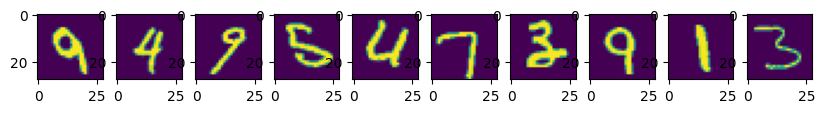

In [19]:
plt.figure(figsize=(10,1))
for i,img in enumerate(img64[:10]): #
    plt.subplot(1,10,i+1) #绘制的是1行10列的第i+1张图
    imshow(img)

#### 回顾enumerate

In [21]:
demolst = [i for i in range(10,20)]
for idx,item in enumerate(demolst): 
    print(idx,item)

0 10
1 11
2 12
3 13
4 14
5 15
6 16
7 17
8 18
9 19


In [22]:
labels[:10]

tensor([9, 4, 9, 5, 4, 7, 3, 9, 1, 3])

可以看到都是一一对应的

### 创建全连接模型

每张图片展开的像素个数

在 PyTorch 中进行手写数字识别（例如使用经典的 **MNIST 数据集**）时，“**展平**”是一个非常重要的预处理步骤。下面我们来详细解释一下它的含义和原因。

---

## ✅ 什么是“展平”？

“**展平（Flatten）**”指的是将图像数据从多维张量转换为一维向量的过程。

### 示例：
- MNIST 图像的原始形状是：`(1, 28, 28)`，表示 1 个通道（灰度图），高 28 像素，宽 28 像素。
- 展平后变成：`(784,)`，也就是 `28 * 28 = 784` 的一维向量。

```python
import torch

x = torch.randn(1, 28, 28)          # 原始图像
x_flattened = x.view(-1)            # 展平成一个一维向量，形状变为 (784,)
```

---

## 🤔 为什么要“展平”？

### 1. 全连接层要求输入是一维的
如果你构建的是一个全连接神经网络（Fully Connected Network / MLP），每一层的神经元只接受一维的输入。

例如：
```python
self.fc1 = nn.Linear(28 * 28, 128)
```
这个线性层期望输入是 `(784,)` 这样的一维向量。

如果不展平，直接传入 `(1, 28, 28)` 的三维张量，会报错。

---

### 2. 卷积神经网络 CNN 不需要手动展平（但最后仍要）
如果你使用的是卷积神经网络（CNN），比如 `nn.Conv2d` 层，那么输入可以保持为 `(C, H, W)` 的格式（如 `(1, 28, 28)`）。但在经过卷积层和池化层之后，在进入全连接层之前，仍然需要对特征图进行展平操作。

示例：
```python
x = F.relu(self.conv1(x))        # 输出可能是 (batch_size, 16, 24, 24)
x = x.view(x.size(0), -1)        # 展平成 (batch_size, 16*24*24)
x = self.fc1(x)
```

---

## 📌 总结

| 情况 | 是否需要展平 |
|------|----------------|
| 使用全连接网络（MLP） | ✅ 必须展平 |
| 使用 CNN（卷积层） | ❌ 初期不需要，但最终进入全连接层前需要展平 |
| 输入数据为图像（如 MNIST） | ✅ 通常需要从 `(1, 28, 28)` 变成 `(784,)` |

---

如果你正在构建一个简单的模型用于 MNIST 手写识别，可以参考如下代码片段：

```python
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                   # 自动将 (1, 28, 28) 展平为 (784,)
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)
```

---

如有需要，我可以提供完整的训练代码 😊

In [39]:
28*28

784

类别个数

In [23]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [24]:
 class Model(nn.Module): 
     def __init__(self):
         super().__init__()  
         self.liner_1 = nn.Linear(784,120)
         self.liner_2 = nn.Linear(120,84)
         self.liner_3 = nn.Linear(84,10) #0-9所以是10分类
     def forward(self,input): 
         #把输入从形状如 (batch_size, 1, 28, 28) 或 (batch_size, 28, 28) 转换为 (batch_size, 784)，也就是把图像数据展平为一维向量。
         x = input.view(-1,28*28) #-1 表示自动推断 batch size 大小（即保留原来的 batch 数量）
         # 28*28=784 表示每个图像被拉成一个长度为 784 的一维向量
         '''
         假设输入是一个 batch 的图像，形状是 (64, 1, 28, 28)，表示有 64 张图，每张图是 1 通道、28x28 的灰度图。

执行展平后变为：x = input.view(-1, 784)  # => (64, 784)  
因为你使用的是全连接神经网络（MLP），它只能处理一维的数据。不像卷积神经网络（CNN）可以处理 (C, H, W) 格式的图像数据，全连接层要求输入是一维的特征向量。

如果不展平，直接传入 (1, 28, 28) 或 (28, 28) 的数据，会因为维度不匹配而报错。
         
         '''
         x = F.relu(self.liner_1(x))  
         x = F.relu(self.liner_2(x))
         x = F.relu(self.liner_3(x))
         return x

#### 创建模型

In [25]:
model = Model()

In [26]:
model

Model(
  (liner_1): Linear(in_features=784, out_features=120, bias=True)
  (liner_2): Linear(in_features=120, out_features=84, bias=True)
  (liner_3): Linear(in_features=84, out_features=10, bias=True)
)

#### 创建损失函数和优化函数

In [27]:
lr = 0.001
lossfn = nn.CrossEntropyLoss()
optm = torch.optim.Adam(model.parameters(),lr=lr)

In [30]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
    
   
    #创建俩列表接收损失值和精度值
    train_loss_lst = []
    train_acc_lst = []
    tst_loss_lst=[]
    tst_acc_lst=[]
  
    Model_m.train()  # 设置为训练模式
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了灯饰可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval()
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


In [32]:
model_gpu = Model()
optim_gpu = torch.optim.Adam(model_gpu.parameters(),lr=0.0001)
loss_fn_gpu = nn.CrossEntropyLoss() 
# DL_train = DataLoader(DS_train,batch_size=batch,shuffle=True)
# DL_test = DataLoader(DS_test,batch_size=batch)  
DL_train = DataLoader(DS_Train,batch_size=64,shuffle=True)
DL_test = DataLoader(DS_Test,batch_size=256,shuffle=False)

epochs = 50 

train_loss_gpu=[] 
train_acc_gpu =[] 
tst_loss_gpu = [] 
tst_acc_gpu=[] 
for epoch in range(epochs): 
    epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc = fit_gpu(Train_DL=DL_train,TST_DL=DL_test,Model_m=model_gpu,epoch_=epoch,optim=optim_gpu,loss_fn=loss_fn_gpu)
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)

epoch:0 | loss:0.019 | acc:0.649 | tstloss:0.003 | tstacc:0.730
epoch:1 | loss:0.012 | acc:0.733 | tstloss:0.003 | tstacc:0.744
epoch:2 | loss:0.011 | acc:0.742 | tstloss:0.003 | tstacc:0.750
epoch:3 | loss:0.009 | acc:0.796 | tstloss:0.002 | tstacc:0.847
epoch:4 | loss:0.007 | acc:0.852 | tstloss:0.002 | tstacc:0.852
epoch:5 | loss:0.007 | acc:0.857 | tstloss:0.002 | tstacc:0.855
epoch:6 | loss:0.006 | acc:0.861 | tstloss:0.002 | tstacc:0.857
epoch:7 | loss:0.006 | acc:0.864 | tstloss:0.002 | tstacc:0.861
epoch:8 | loss:0.006 | acc:0.867 | tstloss:0.002 | tstacc:0.863
epoch:9 | loss:0.006 | acc:0.869 | tstloss:0.001 | tstacc:0.867
epoch:10 | loss:0.006 | acc:0.872 | tstloss:0.001 | tstacc:0.868
epoch:11 | loss:0.005 | acc:0.874 | tstloss:0.001 | tstacc:0.869
epoch:12 | loss:0.005 | acc:0.875 | tstloss:0.001 | tstacc:0.870
epoch:13 | loss:0.005 | acc:0.877 | tstloss:0.001 | tstacc:0.871
epoch:14 | loss:0.005 | acc:0.879 | tstloss:0.001 | tstacc:0.873
epoch:15 | loss:0.005 | acc:0.880 |

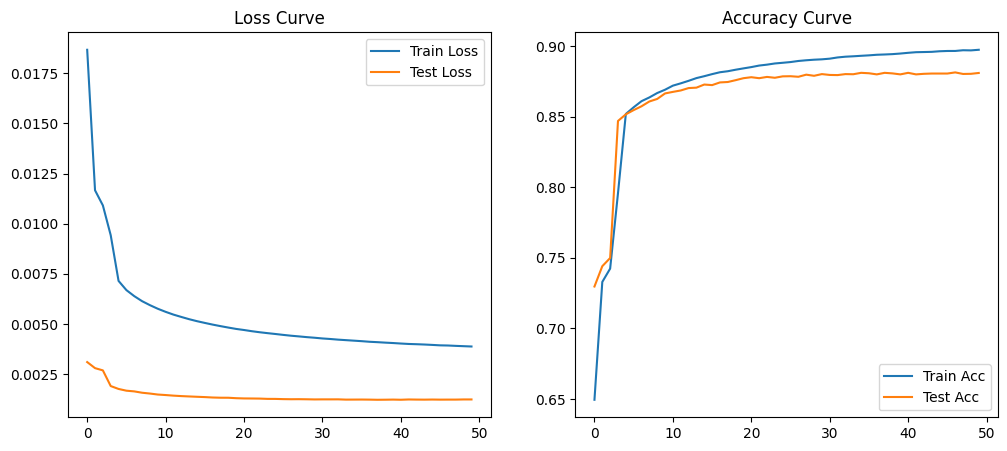

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_gpu, label='Train Loss')
plt.plot(tst_loss_gpu, label='Test Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_acc_gpu, label='Train Acc')
plt.plot(tst_acc_gpu, label='Test Acc')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

#### 改进版

In [37]:
def fit_gpu(Train_DL, TST_DL, Model_m, epoch_, optim, loss_fn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
    Model_m.train()

    # ---------------------
    # 第一阶段：训练阶段
    # ---------------------
    for x, y in Train_DL:
        x, y = x.to(device), y.to(device)

        y_pred_logits = Model_m(x)  # 模型输出是 logits
        loss = loss_fn(y_pred_logits, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

    # ---------------------
    # 第二阶段：评估阶段（在整个 epoch 所有 batch 完成后）
    # ---------------------
    Model_m.eval()  # 切换为评估模式

    train_correct = 0
    train_total = 0
    train_running_loss = 0.0

    with torch.no_grad():
        for x, y in Train_DL:  # 再次遍历整个训练集
            x, y = x.to(device), y.to(device)
            y_pred_logits = Model_m(x)
            loss = loss_fn(y_pred_logits, y)

            y_pred = torch.argmax(y_pred_logits, dim=1)
            train_correct += (y_pred == y).sum().item()
            train_total += y.size(0)
            train_running_loss += loss.item() * y.size(0)

    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = train_correct / train_total

    # ---------------------
    # 测试阶段
    # ---------------------
    test_correct = 0
    test_total = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for x, y in TST_DL:
            x, y = x.to(device), y.to(device)
            y_pred_logits = Model_m(x)
            loss = loss_fn(y_pred_logits, y)

            y_pred = torch.argmax(y_pred_logits, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item() * y.size(0)

    test_epoch_loss = test_running_loss / test_total
    test_epoch_acc = test_correct / test_total

    print(
        f'epoch:{epoch_} | loss:{train_epoch_loss:.3f} | acc:{train_epoch_acc:.3f} | '
        f'tstloss:{test_epoch_loss:.3f} | tstacc:{test_epoch_acc:.3f}'
    )

    return train_epoch_loss, train_epoch_acc, test_epoch_loss, test_epoch_acc

In [38]:
model_gpu = Model()
optim_gpu = torch.optim.Adam(model_gpu.parameters(),lr=0.0001)
loss_fn_gpu = nn.CrossEntropyLoss() 
# DL_train = DataLoader(DS_train,batch_size=batch,shuffle=True)
# DL_test = DataLoader(DS_test,batch_size=batch)  
DL_train = DataLoader(DS_Train,batch_size=64,shuffle=True)
DL_test = DataLoader(DS_Test,batch_size=256,shuffle=False)

epochs = 50 

train_loss_gpu=[] 
train_acc_gpu =[] 
tst_loss_gpu = [] 
tst_acc_gpu=[] 
for epoch in range(epochs): 
    epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc = fit_gpu(Train_DL=DL_train,TST_DL=DL_test,Model_m=model_gpu,epoch_=epoch,optim=optim_gpu,loss_fn=loss_fn_gpu)
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)

epoch:0 | loss:0.852 | acc:0.706 | tstloss:0.837 | tstacc:0.709
epoch:1 | loss:0.762 | acc:0.719 | tstloss:0.749 | tstacc:0.721
epoch:2 | loss:0.723 | acc:0.730 | tstloss:0.715 | tstacc:0.732
epoch:3 | loss:0.696 | acc:0.737 | tstloss:0.691 | tstacc:0.738
epoch:4 | loss:0.676 | acc:0.742 | tstloss:0.671 | tstacc:0.742
epoch:5 | loss:0.660 | acc:0.746 | tstloss:0.658 | tstacc:0.743
epoch:6 | loss:0.646 | acc:0.749 | tstloss:0.647 | tstacc:0.748
epoch:7 | loss:0.633 | acc:0.754 | tstloss:0.633 | tstacc:0.753
epoch:8 | loss:0.622 | acc:0.757 | tstloss:0.624 | tstacc:0.755
epoch:9 | loss:0.614 | acc:0.759 | tstloss:0.617 | tstacc:0.757
epoch:10 | loss:0.608 | acc:0.760 | tstloss:0.612 | tstacc:0.758
epoch:11 | loss:0.597 | acc:0.763 | tstloss:0.602 | tstacc:0.761
epoch:12 | loss:0.593 | acc:0.764 | tstloss:0.600 | tstacc:0.761
epoch:13 | loss:0.584 | acc:0.767 | tstloss:0.594 | tstacc:0.764
epoch:14 | loss:0.581 | acc:0.767 | tstloss:0.591 | tstacc:0.763
epoch:15 | loss:0.575 | acc:0.768 |

#### 最终改进版本 

In [ ]:
def fit_gpu(Train_DL, TST_DL, Model_m, epoch_, optim, loss_fn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
    Model_m.train()

    # 用于缓存训练过程中的预测结果和真实标签
    all_train_preds = []
    all_train_targets = []
    train_running_loss = 0.0

    # ---------------------
    # 第一阶段：训练 + 缓存预测结果
    # ---------------------
    for x, y in Train_DL:
        x, y = x.to(device), y.to(device)

        y_pred_logits = Model_m(x)
        loss = loss_fn(y_pred_logits, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        with torch.no_grad():
            y_pred = torch.argmax(y_pred_logits, dim=1)
            all_train_preds.append(y_pred.cpu())
            all_train_targets.append(y.cpu())
            train_running_loss += loss.item() * y.size(0)

    # 拼接所有缓存的预测结果和标签
    all_train_preds = torch.cat(all_train_preds)
    all_train_targets = torch.cat(all_train_targets)

    train_correct = (all_train_preds == all_train_targets).sum().item()
    train_total = len(all_train_targets)
    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = train_correct / train_total

    # ---------------------
    # 测试阶段：同理可缓存测试结果
    # ---------------------
    Model_m.eval()
    test_correct = 0
    test_total = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for x, y in TST_DL:
            x, y = x.to(device), y.to(device)
            y_pred_logits = Model_m(x)
            loss = loss_fn(y_pred_logits, y)

            y_pred = torch.argmax(y_pred_logits, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item() * y.size(0)

    test_epoch_loss = test_running_loss / test_total
    test_epoch_acc = test_correct / test_total

    print(
        f'epoch:{epoch_} | loss:{train_epoch_loss:.3f} | acc:{train_epoch_acc:.3f} | '
        f'tstloss:{test_epoch_loss:.3f} | tstacc:{test_epoch_acc:.3f}'
    )

    return train_epoch_loss, train_epoch_acc, test_epoch_loss, test_epoch_acc

In [34]:
import pickle as pkl 
with open('./mymodel/forminist.pkl','wb') as f : 
    pkl.dump(model_gpu,f)

你这段代码是一个 **用于训练 PyTorch 模型的完整训练 + 验证函数 `fit_gpu()`**。它负责在 GPU（或 CPU）上进行一个 epoch 的模型训练和验证，并返回该 epoch 的训练损失、训练准确率、测试损失和测试准确率。

---

## 📌 函数定义

```python
def fit_gpu(Train_DL, TST_DL, Model_m, epoch_, optim, loss_fn):
```

| 参数 | 类型 | 含义 |
|------|------|------|
| `Train_DL` | DataLoader | 训练数据集，每次迭代输出一个 batch 的 `(x, y)` |
| `TST_DL` | DataLoader | 测试/验证数据集 |
| `Model_m` | nn.Module | 要训练的神经网络模型 |
| `epoch_` | int | 当前是第几个 epoch |
| `optim` | Optimizer | 优化器（如 Adam）|
| `loss_fn` | Loss Function | 损失函数（如 CrossEntropyLoss）|

---

## 🧠 第一部分：初始化变量和设备设置

```python
correct = 0
total = 0
running_loss = 0
tstcorrect = 0
tsttotal = 0
tstrunning_loss = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model_m.to(device)
```

- 定义了一些变量来统计：
  - 正确预测的数量 (`correct`)
  - 总样本数 (`total`)
  - 损失值 (`running_loss`)
- 将模型移动到 GPU 或 CPU 上运行

---

## 📊 创建列表记录指标（这部分其实没用）

```python
train_loss_lst = []
train_acc_lst = []
tst_loss_lst=[]
tst_acc_lst=[]
```

这些列表在函数中被创建了，但没有被使用，也没有返回。可以删掉，或者留着以后扩展用途。

---

## 🔁 第二部分：训练阶段（Training Loop）

```python
Model_m.train()  # 设置为训练模式
for x, y in Train_DL:
    x = x.to(device)
    y = y.to(device)

    y_pred = Model_m(x)
    loss = loss_fn(y_pred, y)

    optim.zero_grad()
    loss.backward()
    optim.step()

    with torch.no_grad():
        y_pred = torch.argmax(y_pred,dim=1)
        correct += (y_pred == y).sum().item()
        total += y.size(0)
        running_loss += loss.item()
```

### ✅ 这段代码做了什么？

- **将每个 batch 的输入数据放到 GPU 上**
- **前向传播（forward pass）**
- **计算损失（loss）**
- **清空梯度、反向传播（backward）、更新参数（step）**

⚠️ **重点问题在这里！**

你在每个 batch 中都进行了以下操作：

```python
with torch.no_grad():
    y_pred = torch.argmax(...)  # 获取预测类别
    correct += ...             # 累加正确数量
    total += ...               # 累加总样本数
    running_loss += ...        # 累加损失
```

这会导致你在 **同一个 batch 上重复评估**，并导致每个 batch 都统计一次 accuracy 和 loss，最后又除以整个 dataset 的长度，逻辑混乱。

> ❗这是不推荐的做法。正确的做法是在所有 batch 都训练完后，再统一做一次评估。

---

## 📉 第三部分：计算整个 epoch 的训练损失和准确率

```python
epoch_acc = correct / total
epoch_loss = running_loss / len(Train_DL.dataset)
```

- `correct / total`: 计算整个训练集上的准确率
- `running_loss / len(Train_DL.dataset)`: 计算平均损失

⚠️ 但上面我们已经说过，这个 `correct` 和 `running_loss` 是在每个 batch 上累加的，这样会引入误差。

---

## 🧪 第四部分：测试阶段（Validation Loop）

```python
Model_m.eval()
with torch.no_grad(): 
    for x, y in TST_DL:
        x, y = x.to(device), y.to(device)
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)

        y_pred = torch.argmax(y_pred, dim=1)
        tstcorrect += (y_pred == y).sum().item()
        tsttotal += y.size(0)
        tstrunning_loss += loss.item()
```

- 使用 `Model_m.eval()` 关闭 dropout/batchnorm 的训练行为
- 对测试集逐个 batch 进行推理
- 统计预测正确的数量和损失

---

## 📈 最后：计算测试集的准确率和损失

```python
tstepoch_acc = tstcorrect / tsttotal
tstepoch_loss = tstrunning_loss / len(TST_DL.dataset)
```

- `tstcorrect / tsttotal`: 测试集准确率
- `tstrunning_loss / len(TST_DL.dataset)`: 测试集平均损失

---

## 🖨️ 打印日志信息

```python
print(
    f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | '
    f'tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
)
```

输出类似：

```
epoch:0 | loss:0.000 | acc:0.531 | tstloss:0.006 | tstacc:0.385
```

---

## 📤 返回值

```python
return epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc
```

返回当前 epoch 的训练和测试损失与准确率，供外部记录使用。

---

## ⚠️ 存在的问题总结

| 问题 | 描述 | 建议解决方式 |
|------|------|--------------|
| ❌ 在每个 batch 中都统计 accuracy 和 loss | 导致统计混乱、结果不可靠 | 改为在整个 epoch 结束后统一统计 |
| ❌ 变量名重复使用 | `y_pred` 被复用，容易出错 | 使用不同变量名区分原始输出和预测类别 |
| ❌ 列表未使用 | `train_loss_lst`, `train_acc_lst` 等未被使用 | 删除或保留作为后续可视化用 |
| ❌ `epoch` 未定义 | 你的 print 中用了 `epoch`，但函数参数是 `epoch_` | 改成 `epoch_` |

---

## ✅ 推荐修复后的版本（简化版）

```python
def fit_gpu(Train_DL, TST_DL, Model_m, epoch_, optim, loss_fn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)

    Model_m.train()
    train_correct = 0
    train_total = 0
    train_running_loss = 0.0

    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)

        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        with torch.no_grad():
            predicted = torch.argmax(y_pred, dim=1)
            train_correct += (predicted == y).sum().item()
            train_total += y.size(0)
            train_running_loss += loss.item() * y.size(0)

    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = train_correct / train_total

    # 测试阶段
    Model_m.eval()
    test_correct = 0
    test_total = 0
    test_running_loss = 0.0

    with torch.no_grad():
        for x, y in TST_DL:
            x = x.to(device)
            y = y.to(device)

            y_pred = Model_m(x)
            loss = loss_fn(y_pred, y)

            predicted = torch.argmax(y_pred, dim=1)
            test_correct += (predicted == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item() * y.size(0)

    test_epoch_loss = test_running_loss / test_total
    test_epoch_acc = test_correct / test_total

    print(
        f'epoch:{epoch_} | loss:{train_epoch_loss:.3f} | acc:{train_epoch_acc:.3f} | '
        f'tstloss:{test_epoch_loss:.3f} | tstacc:{test_epoch_acc:.3f}'
    )

    return train_epoch_loss, train_epoch_acc, test_epoch_loss, test_epoch_acc
```

---

## ✅ 总结一句话：

> 你的 `fit_gpu` 函数实现了完整的训练和测试流程，但在统计指标时存在逻辑错误。建议将训练和测试的指标统计放在各自的循环外，确保每个 epoch 的准确率和损失是基于全部 batch 的结果。

如果你还想了解如何：
- 可视化训练曲线（loss/acc）
- 使用 TensorBoard 监控训练过程
- 添加早停机制（Early Stopping）
- 保存最佳模型

我也可以继续帮你写代码 😊